# Final Feature selection

In [1]:
#imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from BorutaShap import BorutaShap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score
import pickle


In [ ]:
%matplotlib inline
sns.set_palette("Set2")

In [2]:
#load initial cleaned data
df=pd.read_csv(r"..\data\processed\prelim_clean2.csv", index_col=[0])

## Boruta

In [3]:
# no model selected default is Random Forest, if classification is True it is a Classification problem
Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=True)

Feature_Selector.fit(X=df.drop(['target'], axis=1), y=df.target, n_trials=100, random_state=1)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:13:29<00:00, 80.09s/it]

49 attributes confirmed important: ['NACCAGEB', 'MEMORY', 'NACCALZP', 'PROBAD', 'UDSVERTN', 'NACCMOCA', 'CDRSUM', 'NACCETPR', 'BILLS', 'DECCLIN', 'TRAILBLI', 'TRAILALI', 'NACCADMD', 'VEG', 'WEIGHT', 'NACCMMSE', 'REMDATES', 'DECIN', 'MEMUNITS', 'NACCAGE', 'MEMTIME', 'TRAVEL', 'HOMEHOBB', 'TAXES', 'NACCALZD', 'NACCAMD', 'TRAILA', 'UDSBENTD', 'CRAFTDVR', 'NACCAM', 'ANIMALS', 'NACCPPA', 'COGMEM', 'UDSVERFC', 'INDEPEND', 'BIRTHYR', 'MMSEORDA', 'WAIS', 'TRAILB', 'DECAGE', 'LOGIMEM', 'COMMUN', 'PROBADIF', 'CRAFTDRE', 'CRAFTVRS', 'NACCBMI', 'PAYATTN', 'ORIENT', 'NACCNE4S']
485 attributes confirmed unimportant: ['TOBAC30', 'ANXSEV', 'GAMES', 'PRIMLANG', 'NACCLIVS', 'DECCLMOT', 'DIGFORSL', 'COGOTHIF', 'CORTDEF', 'STKIMAG', 'NACCTCSF', 'NACCVASD', 'VISCORR', 'RIGDLOLF', 'DROPACT', 'OTHSLEEP', 'BEPERCH', 'EYEPSP', 'BOWLINC', 'HISPOR', 'NACCMCIE', 'MEMPROB', 'TBI', 'COGOTH3F', 'CVDIMAG1', 'MOCAABST', 'CORT', 'HEARWAID', 'MOMODE', 'HYPERT', 'POSTINST', 'CVDIF', 'PSYCDIS', 'HYPCHOL', 'MMSECOMP', 'COR

In [7]:
Feature_Selector.TentativeRoughFix()

11 tentative features are now accepted: ['COGOTH2' 'NACCTMCI' 'MOCATOTS' 'TRAILARR' 'MOCAORDT' 'MOCAORMO'
 'MOCAORYR' 'NACCNMRI' 'drug_count' 'UDSBENRS' 'DEMUN']
4 tentative features are now rejected: ['UDSBENTC' 'COGOTH3' 'CDRLANG' 'EDUC']


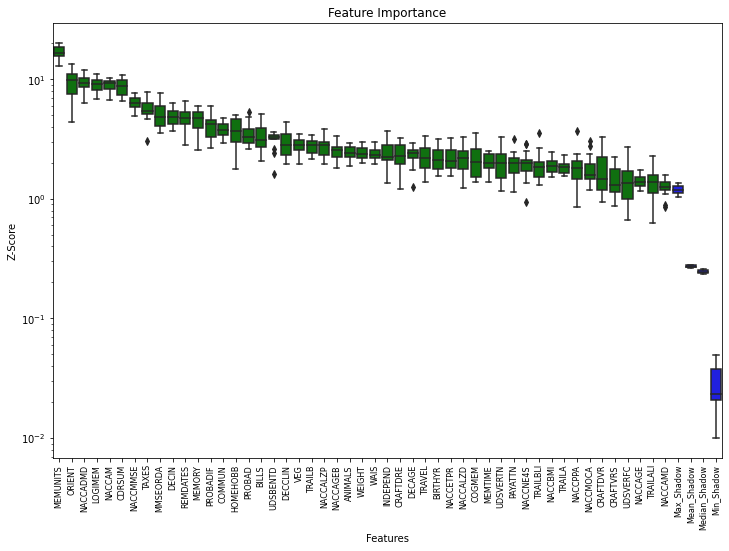

In [4]:
Feature_Selector.plot(which_features="accepted",y_scale='log')


### check if our base model improves 

In [8]:
subset = Feature_Selector.Subset()
subset.drop(['NACCNMRI','DEMUN'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(subset, df['target'], test_size=0.35, random_state=1)

model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(X_train, y_train)
y_pred = model_feat1.predict(X_test)
print(model_feat1.score(X_test, y_test))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))



0.7246852764094144
0.7216642754662841
0.6194581280788177


In [41]:
### add genetics

In [42]:
# subset['NACCNE4S']=df['NACCNE4S']
# subset['NACCAPOE']=df['NACCAPOE']
# X_train, X_test, y_train, y_test = train_test_split(subset, df['target'], test_size=0.35, random_state=1)

# model_feat1 = RandomForestClassifier()
# #train model
# model_feat1.fit(X_train, y_train)
# y_pred = model_feat1.predict(X_test)
# print(model_feat1.score(X_test, y_test))
# print(precision_score(y_test,y_pred))
# print(recall_score(y_test,y_pred))



0.7252326217843459
0.7195467422096318
0.625615763546798


## find which tests these featues are part of which tests and add the rest for engineering

In [9]:
dd=pd.read_csv(r"..\docs\rdd_datadictionary_uds.csv")
import json
with open('../data/processed/forms.txt') as json_file:
    form_key = json.load(json_file)

In [10]:
forms_set=dd['Form'].loc[dd['VariableName'].isin(subset.columns)]
forms_set.unique()
equiv=[form_key[x] for x in forms_set.unique().tolist()]
equiv

['Subject Demographics',
 'Family History',
 'Medications',
 'Physical',
 'CDR® Plus NACC FTLD',
 'Functional Activities Questionnaire(FAQ)',
 'Clinician Judgment of Symptoms',
 'Neuropsychological Battery',
 'Neuropsychological Battery',
 'Neuropsychological Battery',
 'Clinician Diagnosis']

In [28]:
#u_forms=forms_set.unique().tolist()
u_forms=['b4','b7','c1c2','c1','c2']
other_vars=dd['VariableName'].loc[dd['Form'].isin(u_forms)]

In [43]:
broad_subset=df[df.columns.intersection(other_vars)]
broad_subset=pd.concat([broad_subset, subset], axis=1, sort=False)
broad_subset

,MEMORY,ORIENT,JUDGMENT,COMMUN,HOMEHOBB,PERSCARE,CDRSUM,CDRGLOB,COMPORT,CDRLANG,...,COGOTH2,NACCTMCI,MOCATOTS,TRAILARR,MOCAORDT,MOCAORMO,MOCAORYR,drug_count,UDSBENRS,NACCAPOE
0,0.5,0.5,1.0,0.5,0.5,0.0,3.0,0.5,-4.0,-4.0,...,-4.0,1,-4.0,-4.0,-4.0,-4.0,-4.0,5,-4.0,1
2,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,...,0.0,1,-4.0,97.0,-4.0,-4.0,-4.0,7,-4.0,1
4,0.5,0.5,0.5,1.0,0.5,0.0,3.0,0.5,0.0,0.5,...,0.0,2,-4.0,1.0,-4.0,-4.0,-4.0,8,-4.0,1
5,0.5,0.0,1.0,0.5,0.5,0.0,2.5,0.5,0.5,0.5,...,0.0,2,-4.0,0.0,-4.0,-4.0,-4.0,2,-4.0,2
6,0.5,0.5,0.5,0.5,0.5,0.0,2.5,0.5,0.0,0.0,...,0.0,4,-4.0,0.0,-4.0,-4.0,-4.0,3,-4.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,-4.0,...,-4.0,1,-4.0,-4.0,-4.0,-4.0,-4.0,5,-4.0,9
18759,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,...,0.0,3,-4.0,1.0,-4.0,-4.0,-4.0,9,-4.0,9
18764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,3,-4.0,-4.0,-4.0,-4.0,-4.0,3,-4.0,1
18767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,-4.0,0.0,-4.0,-4.0,-4.0,7,-4.0,1


### let's try the forest on this broad feature list

In [44]:
X_train, X_test, y_train, y_test = train_test_split(broad_subset, df['target'], test_size=0.35, random_state=1)

model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(X_train, y_train)
y_pred = model_feat1.predict(X_test)
print(model_feat1.score(X_test, y_test))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))



0.722495894909688
0.7213352685050798
0.6120689655172413


### save broad and subset features

In [33]:
pickle.dump(broad_subset.columns, open('../models/01final_features_broad.sav', 'wb'))
pickle.dump(subset.columns, open('../models/01final_features_res.sav', 'wb'))


# Feature engineering + shap

In [34]:
#import
# Importing modules to create our layers and model.
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler

In [35]:
#normalize to 0-1
scaler = MinMaxScaler()
normalized = scaler.fit_transform(broad_subset)

In [36]:
# Defining the level of compression of the hidden layer. Basically, as the input is passed through the encoding layer, it will come out smaller if you want it to find salient features. If I choose num of columns for my encoding dimension, there would be a compression factor of 1, or nothing.
encoding_dim = round(.75*subset.shape[1])
input_dim = Input(shape=(subset.shape[1], ))
# This is the size of the output. We want to generate 28 x 28 pictures in the end, so this is the size we're looking for. 
output_dim = subset.shape[1]
encoded = Dense(encoding_dim, activation='relu')(input_dim)
decoded = Dense(output_dim, activation='sigmoid')(encoded)

In [37]:
# encoder
autoencoder = Model(input_dim, decoded)
# intermediate result
encoder = Model(input_dim, encoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')#mean_squared_error

In [38]:
X_train, X_test, y_train, y_test = train_test_split(subset, df['target'], test_size=0.35, random_state=1)
autoencoder.fit(X_train, X_train,
                epochs=550,
                batch_size=60,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 3393 samples, validate on 1827 samples
Epoch 1/550
3393/3393 [==============================] - 0s 60us/step - loss: -17869.7519 - val_loss: -44655.0430
Epoch 2/550
3393/3393 [==============================] - 0s 25us/step - loss: -84974.6326 - val_loss: -140624.4265
Epoch 3/550
3393/3393 [==============================] - 0s 26us/step - loss: -218824.9756 - val_loss: -320678.0198
Epoch 4/550
3393/3393 [==============================] - 0s 26us/step - loss: -441821.3569 - val_loss: -594316.0878
Epoch 5/550
3393/3393 [==============================] - 0s 26us/step - loss: -758763.6078 - val_loss: -962761.3116
Epoch 6/550
3393/3393 [==============================] - 0s 26us/step - loss: -1168703.9139 - val_loss: -1423453.4754
Epoch 7/550
3393/3393 [==============================] - 0s 25us/step - loss: -1666594.3215 - val_loss: -1972384.8701
Epoch 8/550
3393/3393 [==============================] - 0s 26us/step - loss: -2253353.9421 - val_loss: -2610607.9007
Epoch 9/550
3393/3393

### fit the  forest model

In [39]:
encoded_X_train = encoder.predict(X_train)
encoded_X_val = encoder.predict(X_test)

model_feat1 = RandomForestClassifier()
#train model
model_feat1.fit(encoded_X_train, y_train)
y_pred = model_feat1.predict(encoded_X_val)
print(model_feat1.score(encoded_X_val, y_test))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))



0.5533661740558292
0.4971014492753623
0.4224137931034483


Not sucessful 